In [10]:
import os
import requests
import pandas as pd
from urllib.parse import urljoin
import requests
from bs4 import BeautifulSoup
from vnstock3 import Vnstock
from vnstock3.explorer.misc.gold_price import *
from vnstock3.explorer.misc.exchange_rate import *
from vnstock3.botbuilder.noti import Messenger
from datetime import datetime,timedelta,date
import matplotlib.pyplot as plt
import json

In [9]:
btmc_goldprice()

,name,karat,gold_content,buy_price,sell_price,world_price,time
47,VÀNG MIẾNG SJC (Vàng SJC),24k,999.9,8120000,8400000,0,18/11/2024 09:02
40,VÀNG MIẾNG SJC (Vàng SJC),24k,999.9,8130000,8400000,0,18/11/2024 10:14
6,VÀNG MIẾNG SJC (Vàng SJC),24k,999.9,8120000,8400000,0,18/11/2024 18:54
32,VÀNG MIẾNG SJC (Vàng SJC),24k,999.9,8120000,8400000,0,18/11/2024 10:33
26,VÀNG MIẾNG SJC (Vàng SJC),24k,999.9,8120000,8400000,0,18/11/2024 11:52
13,VÀNG MIẾNG SJC (Vàng SJC),24k,999.9,8120000,8400000,0,18/11/2024 18:52
19,VÀNG MIẾNG SJC (Vàng SJC),24k,999.9,8120000,8400000,0,18/11/2024 16:17
0,VÀNG MIẾNG VRTL (Vàng Rồng Thăng Long),24k,999.9,8223000,8368000,0,18/11/2024 18:54
2,NHẪN TRÒN TRƠN (Vàng Rồng Thăng Long),24k,999.9,8223000,8368000,0,18/11/2024 18:54
7,QUÀ MỪNG BẢN VỊ VÀNG (Quà Mừng Bản Vị Vàng),24k,999.9,8223000,8368000,0,18/11/2024 18:52


In [5]:
date = datetime.today().strftime('%Y-%m-%d')
df = vcb_exchange_rate(date=date)
df['buy _cash'] = df['buy _cash'].replace('-', '0').str.replace(',', '').astype(float)
df = df[df['buy _cash'] != 0]
df['sell'] = df['sell'].str.replace(',', '').astype(float)
df['exchange_rate'] = (df['buy _cash'] + df['sell'])/2
df

,currency_code,currency_name,buy _cash,buy _transfer,sell,date,exchange_rate
2,AUD,AUSTRALIAN DOLLAR,15994.12,"16,155.68",16673.98,2024-11-18,16334.050
3,CAD,CANADIAN DOLLAR,17569.67,"17,747.14",18316.50,2024-11-18,17943.085
4,CHF,SWISS FRANC,27894.40,"28,176.16",29080.10,2024-11-18,28487.250
5,CNY,CHINESE YUAN,3417.36,"3,451.88",3562.62,2024-11-18,3489.990
7,EUR,EURO,26087.86,"26,351.38",27518.31,2024-11-18,26803.085
8,GBP,UK POUND STERLING,31260.90,"31,576.67",32589.70,2024-11-18,31925.300
9,HKD,HONG KONG DOLLAR,3178.97,"3,211.08",3314.10,2024-11-18,3246.535
11,JPY,JAPANESE YEN,158.81,160.41,168.04,2024-11-18,163.425
12,KRW,KOREAN WON,15.73,17.47,18.96,2024-11-18,17.345
19,SGD,SINGAPORE DOLLAR,18425.26,"18,611.37",19208.45,2024-11-18,18816.855


In [4]:
def MFI(stock, start_date, end_date):
    stock = Vnstock().stock(symbol = stock, source = 'VCI')
    df = stock.quote.history(
                            start = start_date, 
                            end = end_date,
                            interval= '1D' 
                            )
    df['Typical Price'] = (df['high'] + df['low'] + df['close'])/3
    df['Money Flow Type'] = ''
    for i in range(0, len(df)-1):
        j = i + 1
        if df.iloc[j, df.columns.get_loc('Typical Price')] >= df.iloc[i, df.columns.get_loc('Typical Price')]:
            df.iloc[j, df.columns.get_loc('Money Flow Type')] = 'P'
        if df.iloc[j, df.columns.get_loc('Typical Price')] < df.iloc[i, df.columns.get_loc('Typical Price')]:
            df.iloc[j, df.columns.get_loc('Money Flow Type')] = 'N'
    df = df[1:]
    df.reset_index(inplace=True)
    negav = df.loc[df['Money Flow Type'] == 'N', 'Typical Price'].sum()
    Posi = df.loc[df['Money Flow Type'] == 'P', 'Typical Price'].sum()
    money_ratio = Posi/negav
    MFI = 100 - 100/(1+money_ratio)
    return {'mfi': MFI, 'data' : df}

2024-11-18 21:18:38 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-11-18 21:18:41 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-11-18 21:18:44 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-11-18 21:18:47 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-11-18 21:18:49 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-11-18 21:18:52 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-11-18 21:18:56 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-11-18 21:18:58 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất 

    index       time  open  high   low  close  volume  Typical Price  \
0       1 2024-10-29  26.7  26.9  25.3   25.6   11800      25.933333   
1       2 2024-10-30  27.9  27.9  25.7   25.7    8700      26.433333   
2       3 2024-10-31  25.5  25.8  25.0   25.7   14100      25.500000   
3       4 2024-11-01  25.1  25.7  25.1   25.7    1600      25.500000   
4       5 2024-11-04  25.3  25.4  24.7   25.4    6800      25.166667   
5       6 2024-11-05  25.4  25.8  24.9   25.1   11800      25.266667   
6       7 2024-11-06  25.0  25.6  25.0   25.2   13600      25.266667   
7       8 2024-11-07  25.3  25.5  25.3   25.5    3500      25.433333   
8       9 2024-11-08  25.5  25.5  24.8   25.2   27200      25.166667   
9      10 2024-11-11  25.0  25.0  24.8   25.0   10400      24.933333   
10     11 2024-11-12  25.0  25.0  24.8   24.9    6200      24.900000   
11     12 2024-11-13  24.9  25.0  24.5   25.0   15900      24.833333   
12     13 2024-11-14  24.8  24.8  24.5   24.7   13900      24.66

<Response [200]>

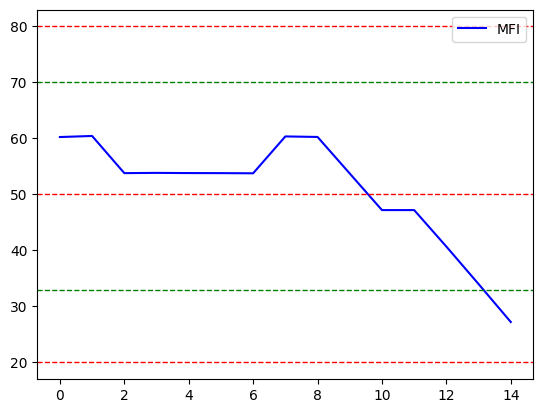

In [ ]:
with open('/home/kiendt/code/ETL/KFinace/Key_info.json') as f:
    data = json.load(f)
stock = "MML"
path = f'/home/kiendt/code/ETL/data/{stock}.jpg'
start = (datetime.today() - timedelta(days=21)).strftime('%Y-%m-%d')
end = datetime.today().strftime('%Y-%m-%d')
df = MFI(stock,start,end)['data']
base_list = df['time']
for i in base_list:
    start = (i - timedelta(days=21)).strftime('%Y-%m-%d')
    end = i.strftime('%Y-%m-%d')
    MFI_value = MFI(stock,start,end)['mfi']
    df.loc[df['time'] == i,'MFI'] = MFI_value
chart = df.plot(kind = 'line',y = 'MFI', color = 'blue')
print(df)
for y in [20, 50, 80]:
    chart.axhline(y=y, color='r', linestyle='--', linewidth=1)
for y in [70, 33]:
    chart.axhline(y=y, color='green', linestyle='--', linewidth=1)
plt.savefig(path)
noti = Messenger(platform='telegram', channel=data['telegram']['channel'], token_key=data['telegram']['token'])
noti.send_message(message=f'{stock} information in {end}', file_path= path,title=f'MFI index in {end}')